In [1]:
# Call the relevant python packages
import numpy as np
import glob, os                          # Operating system module and pathnames
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord

from astropy.wcs import WCS
from astropy import stats

from scipy.stats import gaussian_kde
from astropy.stats.histogram import knuth_bin_width

from scipy.optimize import curve_fit

# Set colour palette & plot layouts
import seaborn as sns     #; sns.set()
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"


# Output plots in Notebook
%matplotlib inline   

In [2]:
# Find the Spitzer FOV
IRAC_FOV = (5.2*u.arcmin)*(5.2*u.arcmin)
#IRAC_FOV =  ((5.2*u.arcmin).to(u.degree))*((5.2*u.arcmin).to(u.degree))
print(IRAC_FOV.to(u.deg**2))

# Now as have two field multiply
print(IRAC_FOV.to(u.deg**2)*2)


0.007511111111111112 deg2
0.015022222222222223 deg2


In [3]:
# Read in the Field Data
#M31fileI1 ="/Users/ojones/Desktop/M32varcat/indivisualM32/MAG_S1_0.csv"
#M31dataI1 = ascii.read(M31fileI1, header_start=0) 

#M31fileI2 ="/Users/ojones/Desktop/M32varcat/indivisualM32/MAG_S2_0.csv"
#M31dataI2 = ascii.read(M31fileI2, header_start=0) 


In [4]:
# Path to indivisual file directiry
inDir = "/Users/ojones/Desktop/M32varcat/indivisualM32/"
outDir = "/Users/ojones/Desktop/M32varcat/indivisualM32/fits/"

In [5]:
# File name without extention
filename = "MAG_S1_0"


In [6]:
# Lists of the M32 and field output files
#resultsfile = M31fileI2

resultsfile = inDir+filename+".csv"
print(resultsfile)


/Users/ojones/Desktop/M32varcat/indivisualM32/MAG_S1_0.csv


In [8]:
# Create a gaussian function

def gaussian(x, a, b, c):
    val = a * np.exp(-(x - b)**2 / c**2)
    return val


In [9]:

# Add an ID column 
data['ID'] = np.arange(len(data))

# Make coordinate for each source 
ra  = Angle(data['RA'], unit=u.deg)
dec = Angle(data['DEC'], unit=u.deg)

# Convert to decimal degrees
ra = ra.deg
dec = dec.deg

# Convert ID column to string
data['ID'] = data['ID'].astype(str)


In [7]:
# Prepare the fits files for Nway Matching 
# Each catalogue needs to have a column RA and DEC providing the coordinates in degrees

# Read in the data file
#resultsfile ="/Users/ojones/Desktop/M32varcat/master.csv"

resultsfile = 'MAG_S1_0.csv'
data = ascii.read(resultsfile, header_start=0) 
data.colnames   # Get the column names


['RA', 'DEC', 'ROUNDESS', 'SHARPNESS', 'MAG1', 'ERR1']

/Users/ojones/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Mean :        -0.13029997573993207
Standard deviation: 0.9677778086142452
Minimum :     -3.0
Maximum :     1.996

25th percentile:    -0.658
Median:             -0.008
75th percentile:    0.538


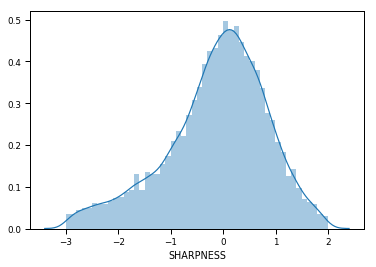

In [10]:
# Plot Gaussians of the sharp values
sns.distplot(data['SHARPNESS'])

print("Mean :       ", np.nanmean(data['SHARPNESS']))
print("Standard deviation:", np.nanstd(data['SHARPNESS']))
print("Minimum :    ", data['SHARPNESS'].min())
print("Maximum :    ", data['SHARPNESS'].max())

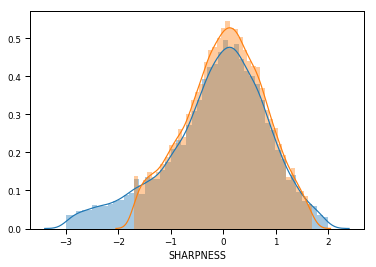

In [11]:
# Detetmine the good sharp values to keep in the catalogue

goodSharp_idx = np.where( (data['SHARPNESS'] < 1.7)
                        & (data['SHARPNESS'] > -1.7))

# Plot Gaussians of the sharp values
sns.distplot(data['SHARPNESS'])
sns.distplot(data['SHARPNESS'][goodSharp_idx])

# Remove the bad Sharp values from the catalogue
data = data[goodSharp_idx]



In [1]:
# Plot Gaussians of the round values

#Plot the distribution with a histogram and maximum likelihood gaussian distribution fit:
#aaa = sns.distplot(data['ROUNDESS'],  kde=False)    # Histogram
aaa = sns.distplot(data['ROUNDESS'],  kde=True)      # Histogram probability

print("Mean :       ", np.nanmean(data['ROUNDESS']))
print("Standard deviation:", np.nanstd(data['ROUNDESS']))
print("Minimum :    ", data['ROUNDESS'].min())
print("Maximum :    ", data['ROUNDESS'].max())

print("")

print("25th percentile:   ", np.nanpercentile(data['ROUNDESS'], 25))
print("Median:            ", np.nanmedian(data['ROUNDESS']))
print("75th percentile:   ", np.nanpercentile(data['ROUNDESS'], 75))

plt.axvline(x=np.nanmedian(data['ROUNDESS']))

NameError: name 'sns' is not defined

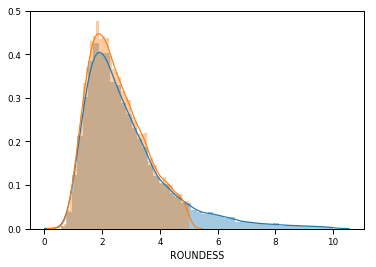

In [13]:
# Exclude sources with Round 3sigma from the mean

goodRound_idx = np.where( (data['ROUNDESS'] < np.nanmean(data['ROUNDESS']) + 3.*np.nanstd(data['ROUNDESS']))
                         &(data['ROUNDESS'] > np.nanmean(data['ROUNDESS']) - 3.*np.nanstd(data['ROUNDESS'])))


goodRound_idx = np.where((data['ROUNDESS'] < 5) 
                         &(data['ROUNDESS'] > 0))

# Plot Gaussians of the round values now excluding the sources with 3sigmma from mean
aaa = sns.distplot(data['ROUNDESS'],  kde=True)                    # Histogram probability
bbb = sns.distplot(data['ROUNDESS'][goodRound_idx],  kde=True)      # Histogram probability

# Remove the bad Round values from the catalogue
data = data[goodRound_idx]



Round =  1.85


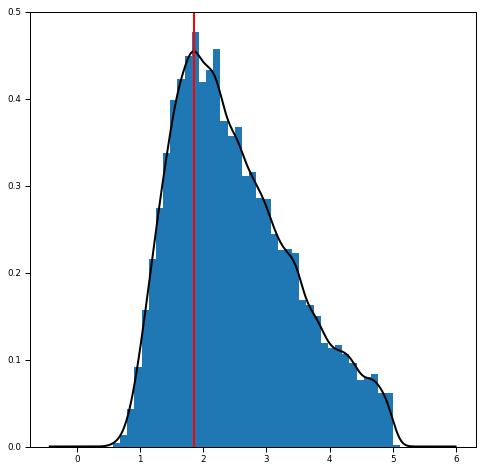

In [14]:
# The KDE analysis to determine the boundary

kde_data = data['ROUNDESS']

# Compute optimum bin width using Knuth's Algorithm
binwidth = (stats.knuth_bin_width(kde_data))
bin_number = (max(kde_data)+binwidth)/binwidth
bins = np.arange(min(kde_data ), max(kde_data) + binwidth, binwidth)

x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)

plt.figure(figsize=(8,8))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 1')
plt.hist(kde_data,bins=bins,density=True,label='Binned data')

# Find the Round value for the peak of the distibution
maxRound_idx = np.where(kde(x_eval) == max(kde(x_eval)))

print("Round =  %.2f" % (x_eval[maxRound_idx]))
plt.axvline(x=np.nanmedian(x_eval[maxRound_idx]), linewidth=2, color='r')


In [15]:
# Fit a gaussian to the data

e = np.random.uniform(0.001, 0.001, len(x_eval))  # Give the data an error value
#e = np.sqrt(kde(x_eval))   # Give the data an error value this is correct for a histogram not a probability

# Fit the gaussian to the data
popt, pcov = curve_fit(gaussian, x_eval, kde(x_eval), sigma=e)

# Print results of fitting the gausian to the model
print("Scale =  %.3f +/- %.3f" % (popt[0], np.sqrt(pcov[0, 0])))
print("Offset = %.3f +/- %.3f" % (popt[1], np.sqrt(pcov[1, 1])))
print("Sigma =  %.3f +/- %.3f" % (popt[2], np.sqrt(pcov[2, 2])))



Scale =  0.424 +/- 0.005
Offset = 2.269 +/- 0.013
Sigma =  1.311 +/- 0.018


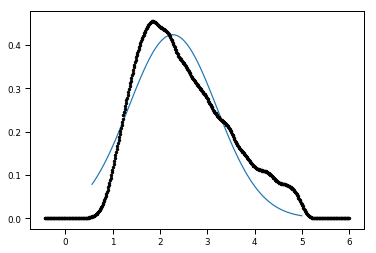

In [16]:
#Plot the data and the gausian model fit to the data 

# Plot data with random error
plt.errorbar(x_eval, kde(x_eval), yerr=e, linewidth=0.1, color='black', fmt='.')

# Plot model
xm = np.linspace(min(kde_data ), max(kde_data), 100)  # 100 evenly spaced points
plt.plot(xm, gaussian(xm, popt[0], popt[1], popt[2]))

In [17]:
#from scipy.stats import norm
#mu, std = norm.fit(data['ROUNDESS'])
#print(mu, std)

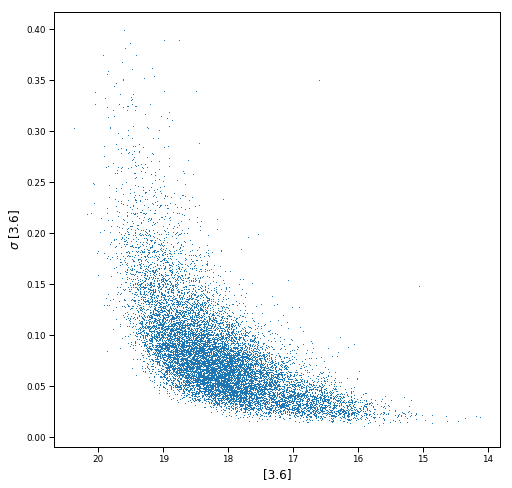

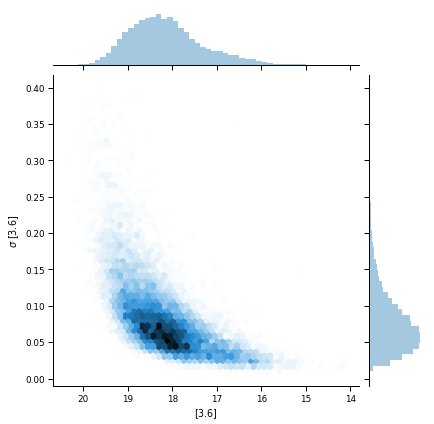

In [18]:
# Plot the Magnitude versus eror in Magnitude

plt.figure(figsize=(8,8))
plt.plot(data['MAG1'], data['ERR1'],',')
#plt.xlim(-1.0, 6.0)
#plt.ylim(20.5, 8.5)
#plt.xlabel('J - [3.6]', size=12)
plt.xlabel('[3.6]', size=12)
plt.ylabel('$\sigma$ [3.6]', size=12)
plt.gca().invert_xaxis()


bbb = sns.jointplot(data['MAG1'], data['ERR1'], kind="hex")
bbb.fig.axes[0].invert_xaxis()
bbb.set_axis_labels("[3.6]", "$\sigma$ [3.6]")

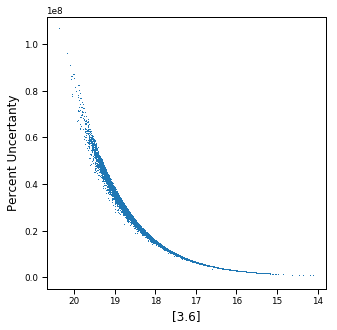

In [19]:
# Plot the Magnitude versus percent error in Magnitude

plt.figure(figsize=(5,5))
plt.plot(data['MAG1'], (10**(data['ERR1']/-2.5))/(10**(data['MAG1']/-2.5)) , ',')
#plt.xlim(-1.0, 6.0)
#plt.ylim(20.5, 8.5)
#plt.xlabel('J - [3.6]', size=12)
plt.xlabel('[3.6]', size=12)
plt.ylabel('Percent Uncertanty', size=12)
plt.gca().invert_xaxis()


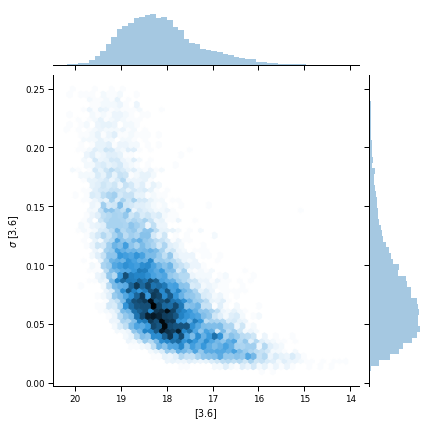

In [20]:
# Remove the faint sources with the percentage high errors in flux 

goodError_idx = np.where( data['ERR1'] < 0.25)
data = data[goodError_idx]

bbb = sns.jointplot(data['MAG1'], data['ERR1'], kind="hex")
bbb.fig.axes[0].invert_xaxis()
bbb.set_axis_labels("[3.6]", "$\sigma$ [3.6]")


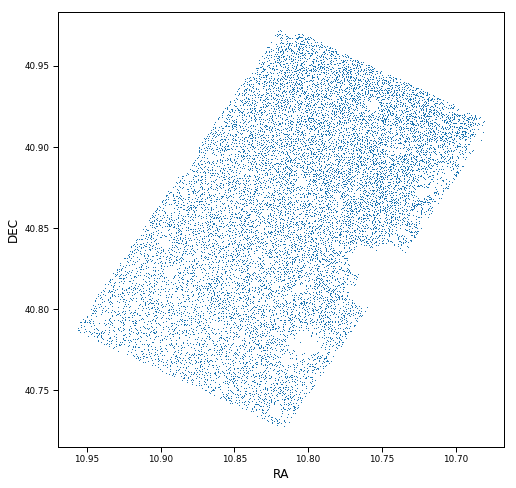

In [21]:
#Plot the RA and DEc of the catalogue
plt.figure(figsize=(8,8))
plt.plot(data['RA'], data['DEC'],',')
#plt.xlim(-1.0, 6.0)
#plt.ylim(20.5, 8.5)
plt.xlabel('RA', size=12)
plt.ylabel('DEC', size=12)
plt.gca().invert_xaxis()

In [22]:
# Add a cut based on RA and DEC for the field

#overlapFOV_idx = np.where( (data['DEC'] < 40.98) &  (data['DEC'] > 40.827))
#data = data[overlapFOV_idx]

print(len(data))

13581


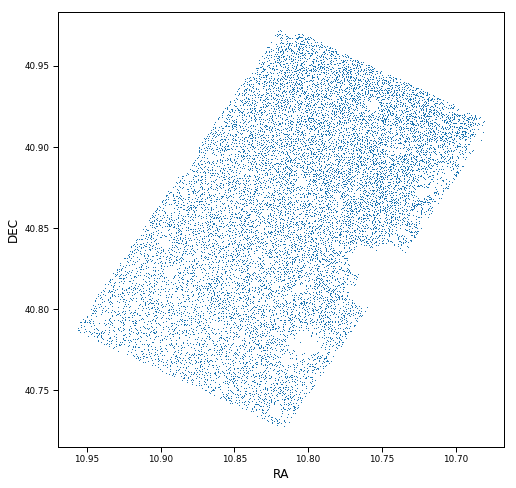

In [23]:
#Plot the RA and DEc of the catalogue
plt.figure(figsize=(8,8))
plt.plot(data['RA'], data['DEC'],',')
#plt.xlim(-1.0, 6.0)
#plt.ylim(20.5, 8.5)
plt.xlabel('RA', size=12)
plt.ylabel('DEC', size=12)
plt.gca().invert_xaxis()

In [24]:
# Plot the data in the browser 
#data.show_in_browser(jsviewer=True)  

In [2]:
# Only include relevnet colums and rename the fields
from astropy.io import ascii
data = ascii.read('MAG_S1_0.csv', header_start=0)
dataShort = data['RA', 'DEC','MAG1', 'ERR1']

# Rename Colums so that NWAY will work 

dataShort.rename_column('MAG1', 'MAG1_x')        # Rename column  MAG BAND_EPOCH    NB Epoch X used for background 
dataShort.rename_column('ERR1', 'ERR1_x')        # Rename column  ERR BAND_EPOCH    NB Epoch X used for background 

dataShort.colnames



['RA', 'DEC', 'MAG1_x', 'ERR1_x']

In [3]:
# Save as a fits table with an ID as a string and RA and DEc in Decmimal degrees
#data.write('/Users/ojones/Desktop/M32varcat/MAG_S2_0.fits')  

dataShort.write("test.fits", overwrite=True)

